In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## Load data

In [2]:
df = pd.read_csv('toyregdata2.csv')
df.head()

,var1,var2
0,0.516399,-0.584753
1,0.570668,-0.458140
2,0.028474,-0.116061
3,0.171522,-0.275226
4,0.685277,-0.458420


## EDA

Pandas has built-in plotting that wraps matplotlib, good for quick looks (not for pretty/custom graphs)

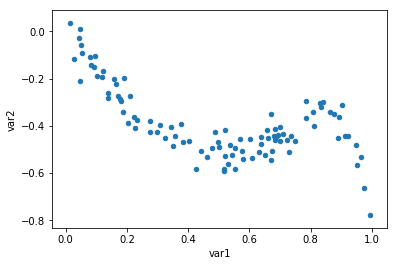

In [6]:
df.plot('var1', 'var2', kind='scatter')

Pandas also allows for Tidyverse-style, chained data wrangling, because the data itself is an instance of `DataFrame`.  See https://stmorse.github.io/journal/tidyverse-style-pandas.html for more ideas...

In [7]:
(df
 .assign(cat = pd.cut(df['var1'], bins=3, labels=['low', 'med', 'high']))
 .groupby('cat')
 .agg('mean')
)

,var1,var2
cat,,
low,0.153590,-0.235655
med,0.518525,-0.492948
high,0.802920,-0.436761


Seaborn has a lot of nice plotting capabilities.

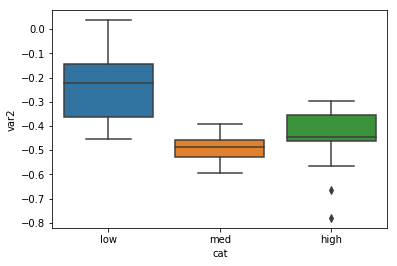

In [5]:
(df
 .assign(cat = pd.cut(df['var1'], bins=3, labels=['low', 'med', 'high']))
 .pipe((sns.boxplot, 'data'), 
       x='cat', y='var2')
)

## Sandbox: Feature engineering / Training

Pull data from pandas DataFrame into numpy array and split into train/test

In [10]:
x = df['var1'].values
y = df['var2'].values

xr, xt, yr, yt = train_test_split(x, y, test_size=0.35)

In [20]:
xrp = PolynomialFeatures(degree=5).fit_transform(xr.reshape(-1,1))
mod = Ridge(alpha=0.01).fit(xrp, yr)

In [21]:
mod.coef_

array([ 0.        , -1.81864417,  1.10393242,  1.29292314,  0.21099982,
       -1.31094794])

The insane code below is not un-typical for a large, custom `matplotlib` plot.  Packages like ggplot, seaborn, pandas all do this kind of code behind-the-scenes, and have limitations that prevent plots like this being even possible.  So if you want to plot anything your heart desires, at some point you need to embrace this style. 

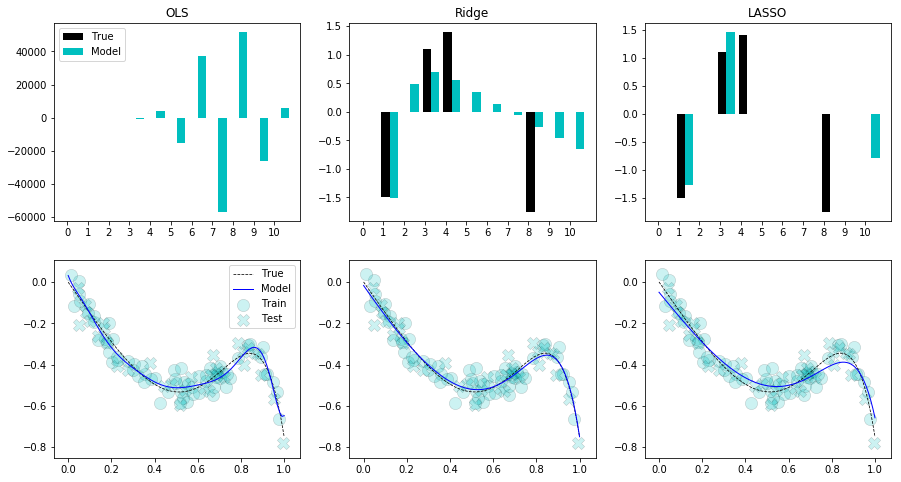

In [17]:
deg = 10  # too many

# we happen to know the "true function" for this toy dataset ...
wtrue = np.array([0, -1.5, 0, 1.1, 1.4, 0, 0, 0, -1.75])
def truefun(x): 
    xpoly = PolynomialFeatures(degree=8).fit_transform(x.reshape((-1,1)))
    return np.dot(xpoly, wtrue)

# transform the training inputs to polynomial
xrp = PolynomialFeatures(degree=deg).fit_transform(xr.reshape((-1,1)))

fig, ax = plt.subplots(2,3, figsize=(15,8))

# fit, test, and plot model
models = [('OLS', LinearRegression()), 
          ('Ridge', Ridge(alpha=0.01)), 
          ('LASSO', Lasso(alpha=0.0005))]
for i,(name,mod) in enumerate(models):
    model = mod.fit(xrp, yr)
    
    ax[0,i].bar(np.arange(9)+0.1, wtrue, 0.4, color='k', label='True')
    ax[0,i].bar(np.arange(deg+1)+0.5, model.coef_, 0.4, color='c', label='Model')
    ax[0,i].set_xticks(np.arange(0,deg+1))
    ax[0,i].set_xticklabels(np.arange(0,deg+1))
    ax[0,i].set_title(name)
    
    # plot true function curve
    xs = np.linspace(0, 1, 100)
    ax[1,i].plot(xs, truefun(xs), 'k--', linewidth=0.75, label='True')

    # plot our model curve
    xsp = PolynomialFeatures(degree=deg).fit_transform(xs.reshape((-1,1)))
    ax[1,i].plot(xs, model.predict(xsp), 'b', linewidth=1, label='Model')

    # plot data
    for xx, yy, m, lab in [(xr, yr, 'o', 'Train'), (xt, yt, 'X', 'Test')]:
        ax[1,i].scatter(xx, yy, marker=m, c='c', label=lab,
                       s=150, 
                       linewidth=0.5,  
                       edgecolors='k',
                       alpha=0.2)
    
# just show legend on first plot
ax[0,0].legend()
ax[1,0].legend()
plt.show()

## Using a `Pipeline`

In [19]:
# a Pipeline pipes data through a sequence of sklearn models.
pipe = Pipeline([('poly', PolynomialFeatures()),
                 ('reg', Ridge())])
gs = GridSearchCV(pipe,
                  cv=3,
                  param_grid={'poly__degree': np.arange(1,10),
                              'reg__alpha': np.logspace(-3,0,4)},
                  return_train_score=True
                 ).fit(xr.reshape((-1,1)), yr)

In [22]:
res = pd.DataFrame(gs.cv_results_)
res.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_poly__degree,param_reg__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
32,0.000628,0.000342,0.823487,0.899468,9,0.001,"{'reg__alpha': 0.001, 'poly__degree': 9}",1,0.927406,0.872634,0.655157,0.927567,0.890966,0.898202,0.000062,8.572024e-06,0.121312,0.022444
28,0.000573,0.000325,0.813721,0.896715,8,0.001,"{'reg__alpha': 0.001, 'poly__degree': 8}",2,0.920930,0.870566,0.633810,0.925778,0.889885,0.893801,0.000007,1.123916e-07,0.129304,0.022634
33,0.000580,0.000341,0.802566,0.891078,9,0.01,"{'reg__alpha': 0.01, 'poly__degree': 9}",3,0.909942,0.865338,0.600870,0.921702,0.901376,0.886193,0.000003,4.724459e-06,0.144311,0.023268
24,0.000617,0.000324,0.799253,0.893031,7,0.001,"{'reg__alpha': 0.001, 'poly__degree': 7}",4,0.911637,0.867505,0.602256,0.923643,0.887896,0.887945,0.000068,1.045242e-05,0.141239,0.023199
29,0.000610,0.000331,0.784711,0.887117,8,0.01,"{'reg__alpha': 0.01, 'poly__degree': 8}",5,0.897343,0.861704,0.559819,0.919666,0.902317,0.879980,0.000054,7.078886e-06,0.160874,0.024195
